# Multi-label Patent Classification with Neural Networks

In [2]:
# import packages 
import tensorflow as tf
import pandas as pd  
import numpy as np 
import gzip
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout, Input, Embedding, Reshape, Flatten, Conv1D, Conv2D, MaxPool2D, GlobalMaxPool1D, SpatialDropout1D
from keras.preprocessing import text, sequence
from keras import utils
from keras import optimizers, models
from sklearn import model_selection, preprocessing, metrics
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import zipfile
import keras_metrics


%matplotlib inline

### Loading the Data

Dataset: 

https://www.google.com/googlebooks/uspto-patents-grants-text.html#2015

The parsing and preprocessing of the patent files can be found here: 

https://github.com/cpapadimitriou/W266-Final-Project/blob/master/preparation/parse_xml.py

In [3]:
# load data 

# features 
current_dir = %pwd
abstract = pd.read_table(current_dir+'/out_zipped/docNumberToAbsText.txt.gz',compression='gzip', header=None)
abstract = abstract[0].str.split('|', expand=True).rename(columns={0:'doc_num',1:'abstract'})

claim = pd.read_table(current_dir+'/out_zipped/docNumberToClaimText.txt.gz',compression='gzip',  header=None)
claim = claim[0].str.split('|', expand=True).rename(columns={0:'doc_num',1:'claim'})

desc = pd.read_table(current_dir+'/out_zipped/docNumberToDescText.txt.gz',compression='gzip', header=None)
desc = desc[0].str.split('|', expand=True).rename(columns={0:'doc_num',1:'desc'})

title = pd.read_table(current_dir+'/out_zipped/docNumberToInvTitle.txt.gz',compression='gzip', header=None)
title = title[0].str.split('|', expand=True).rename(columns={0:'doc_num',1:'title'})

# file_name = pd.read_table(current_dir+'/out_zipped/fileNameToDocNumber.txt.gz',compression='gzip', header=None)
# file_name = file_name[0].str.split('|', expand=True).rename(columns={0:'file_name',1:'doc_num'})

In [4]:
# labels 
# label_names = pd.read_table(current_dir+'/out_zipped/docNumberToLabelSubClass.txt.gz',compression='gzip', header=None)
# label_names = labels[0].str.split('|', expand=True).rename(columns={0:'doc_num'})

labels = pd.read_table(current_dir+'/out_zipped/docNumberToLabelSubClassCode.txt.gz',compression='gzip', header=None)
labels = labels[0].str.split('|', expand=True).rename(columns={0:'doc_num'})

### Data Preparation

In [9]:
# joining the datasets
X = pd.concat([title.set_index('doc_num'), 
           abstract.set_index('doc_num'), 
           claim.set_index('doc_num'), 
           desc.set_index('doc_num')], axis=1).sort_index() #  join='inner'

Y = labels.set_index('doc_num').sort_index() #.set_index(X.index) # fixing the index mismatch
Y.columns=["label{}".format(i) for i in range(1,9)] # renaming columns 

print(X.shape)
print(Y.shape)

(66353, 4)
(66353, 8)


In [47]:
X.head()

title  \
doc_num                                                      
0000009  PROCESS AND APPARATUS FOR AGGLOMERATION OF POW...   
0000098             EXHAUST MIXER AND APPARATUS USING SAME   
0000157    VACUUM CONTROL SYSTEM FOR FOAM DRYING APPARATUS   
0000215         MECHANICALLY TEXTURED ALUMINUM ALLOY SHEET   
0000222                               FLUSHING COMPOSITION   

                                                  abstract  \
doc_num                                                      
0000009  A process and an apparatus for agglomeration o...   
0000098  Disclosed is an exhaust mixer including a pass...   
0000157  The present invention is related to a system f...   
0000215  Non-directional and diffuse reflecting photome...   
0000222  A flushing composition containing a lubricant ...   

                           claim  \
doc_num                            
0000009  P A T E N T C L,A I M S   
0000098                            
0000157      WHAT IS CLAIMED IS:   
0000215                            
0000222                   Claims   

                                                      desc  
doc_num                                                     
0000009  Process and apparatus for agglomeration of pow...  
0000098  EXHAUST MIXER AND APPARATUS USING SAME CROSS-R...  
0000157  VACUUM CONTROL SYSTEM FOR FOAM DRYING APPARATU...  
0000215  MECHANICALLY TEXTURED ALUMINUM ALLOY SHEET 1. ...  
0000222  FLUSHING COMPOSITION This invention relates to...

In [49]:
Y.head()

label1 label2 label3 label4 label5 label6 label7 label8
doc_num                                                        
0000009   F26B   None   None   None   None   None   None   None
0000098   F02K   None   None   None   None   None   None   None
0000157   F26B   F04B   None   None   None   None   None   None
0000215   F21V   None   None   None   None   None   None   None
0000222   F25B   F28G   None   None   None   None   None   None

In [10]:
# data cleaning 
assert Y['label1'].isnull().sum() == 0 # there is no document with 

print("{} documents with null title".format(X['title'].isnull().sum()))
print("{} documents with null claims".format(X['claim'].isnull().sum()))
print("{} documents with null abstract".format(X['abstract'].isnull().sum()))
print("{} documents with null description".format(X['desc'].isnull().sum()))

# remove documents with null sections (title and abstract)
X_clean = X.dropna(how='any')
null_idx = X[~X.index.isin(X_clean.index)].index # storing the removed indices (i.e. document numbers)
assert X.shape[0] - null_idx.shape[0] == X_clean.shape[0] # making sure the row counts match

# removing the documents with null sections from the labels as well 
Y_clean = Y.loc[X_clean.index]

# some checks
assert X_clean.shape[0] == Y_clean.shape[0]
assert ((Y_clean.index == X_clean.index)*1).sum() == X_clean.shape[0]

# lower-casing everything
X_clean = X_clean.apply(lambda x: x.str.lower())
Y_clean = Y_clean.apply(lambda x: x.str.lower())

0 documents with null title
0 documents with null claims
0 documents with null abstract
0 documents with null description


In [11]:
print(X_clean.shape)
print(Y_clean.shape)

(66353, 4)
(66353, 8)


In [12]:
X_clean.head()

title  \
doc_num                                                      
0000009  process and apparatus for agglomeration of pow...   
0000098             exhaust mixer and apparatus using same   
0000157    vacuum control system for foam drying apparatus   
0000215         mechanically textured aluminum alloy sheet   
0000222                               flushing composition   

                                                  abstract  \
doc_num                                                      
0000009  a process and an apparatus for agglomeration o...   
0000098  disclosed is an exhaust mixer including a pass...   
0000157  the present invention is related to a system f...   
0000215  non-directional and diffuse reflecting photome...   
0000222  a flushing composition containing a lubricant ...   

                           claim  \
doc_num                            
0000009  p a t e n t c l,a i m s   
0000098                            
0000157      what is claimed is:   
0000215                            
0000222                   claims   

                                                      desc  
doc_num                                                     
0000009  process and apparatus for agglomeration of pow...  
0000098  exhaust mixer and apparatus using same cross-r...  
0000157  vacuum control system for foam drying apparatu...  
0000215  mechanically textured aluminum alloy sheet 1. ...  
0000222  flushing composition this invention relates to...

In [13]:
Y_clean.head()

label1 label2 label3 label4 label5 label6 label7 label8
doc_num                                                        
0000009   f26b   None   None   None   None   None   None   None
0000098   f02k   None   None   None   None   None   None   None
0000157   f26b   f04b   None   None   None   None   None   None
0000215   f21v   None   None   None   None   None   None   None
0000222   f25b   f28g   None   None   None   None   None   None

In [14]:
# Creating dataset 
data = pd.DataFrame()

# concat the text of all patent sections and join the labels
data['full_text'] = X_clean['title'] + " " + X_clean['claim'] + " " + X_clean['abstract'] + " " + X_clean['desc']

# using only the first label  
data['label1'] = Y_clean['label1'] 

# using all labels, merging them in a list and removing None values
data['labels'] = Y_clean.values.tolist()
data['labels'] = data['labels'].apply(lambda x: list(filter(None, x)))

In [15]:
data.head()

full_text label1  \
doc_num                                                             
0000009  process and apparatus for agglomeration of pow...   f26b   
0000098  exhaust mixer and apparatus using same  disclo...   f02k   
0000157  vacuum control system for foam drying apparatu...   f26b   
0000215  mechanically textured aluminum alloy sheet  no...   f21v   
0000222  flushing composition claims a flushing composi...   f25b   

               labels  
doc_num                
0000009        [f26b]  
0000098        [f02k]  
0000157  [f26b, f04b]  
0000215        [f21v]  
0000222  [f25b, f28g]

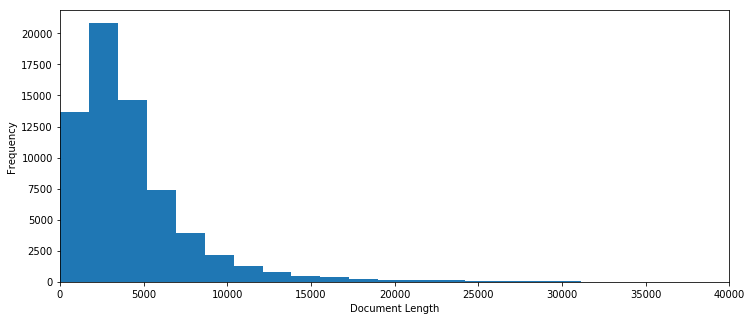

In [21]:
# histogram of document length 
doc_lenghts = data.full_text.str.split().apply(lambda x: len(x))
plt.figure(figsize=(12,5))
plt.hist(doc_lenghts, bins=100)
plt.xlim((0,40000))
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.show()

In [37]:
# Bokeh for plotting.
import bokeh.plotting as bp
from bokeh.models import HoverTool
bp.output_notebook()

# Helper code for plotting histograms
def plot_length_histogram(lengths, x_range=[0,40000], bins=40, normed=False):
    hist, bin_edges = np.histogram(a=lengths, bins=bins, normed=normed, range=x_range)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
    bin_widths =  (bin_edges[1:] - bin_edges[:-1])

    hover = HoverTool(tooltips=[("bucket", "@x"), ("count", "@top")], mode="vline")
    fig = bp.figure(plot_width=800, plot_height=400, tools=[hover])
    fig.vbar(x=bin_centers, width=bin_widths, top=hist, hover_fill_color="firebrick")
    fig.y_range.start = 0
    fig.x_range.start = 0
    fig.xaxis.axis_label = "Document Length"
    fig.yaxis.axis_label = "Frequency"
    output_file("hist.html")
    bp.show(fig)
    
plot_length_histogram(doc_lenghts)

In [22]:
# examing the document length 
print("Average document length: {} words".format(round(np.mean(doc_lenghts))))
print("Median document length: {} words".format(round(np.median(doc_lenghts))))
print("Max document length: {} words".format(round(np.max(doc_lenghts))))
print("Min document length: {} words".format(round(np.min(doc_lenghts))))

Average document length: 4205 words
Median document length: 3355.0 words
Max document length: 172749 words
Min document length: 17 words


In [18]:
# average number of labels per document 
print("Avg. number of labels in dataset: {}".format(data['labels'].apply(lambda x: len(x)).mean()))

Avg. number of labels in dataset: 1.3957771314032523


### Encoding Labels with MultiLabelBinarizer

In [23]:
data['labels'].head()

doc_num
0000009          [f26b]
0000098          [f02k]
0000157    [f26b, f04b]
0000215          [f21v]
0000222    [f25b, f28g]
Name: labels, dtype: object

In [24]:
# converting labels into a binarized matrix with the labels as columns 
# and each patent document represented in one row
mlb = preprocessing.MultiLabelBinarizer()
labels = mlb.fit_transform(data['labels'])

# checking that the conversion worked as desired by verifying the counts of labels for each document prior and post 
assert data['labels'].apply(lambda x: len(x)).values.sum() == np.array(pd.DataFrame(labels).apply(lambda x: x.sum(),axis=1)).sum()

In [464]:
labels_df.iloc[:,[538]].sum()   #470

transmission of digital information, e.g. telegraphic communication     1300
dtype: int64

In [25]:
labels_df = pd.DataFrame(labels, columns=mlb.classes_)  #.apply(lambda x: x.sum(),axis=1)
labels_df.head()

f01b  f01c  f01d  f01k  f01l  f01m  f01n  f01p  f02b  f02c  ...   f41a  \
0     0     0     0     0     0     0     0     0     0     0  ...      0   
1     0     0     0     0     0     0     0     0     0     0  ...      0   
2     0     0     0     0     0     0     0     0     0     0  ...      0   
3     0     0     0     0     0     0     0     0     0     0  ...      0   
4     0     0     0     0     0     0     0     0     0     0  ...      0   

   f41b  f41c  f41f  f41g  f41h  f41j  f42b  f42c  f42d  
0     0     0     0     0     0     0     0     0     0  
1     0     0     0     0     0     0     0     0     0  
2     0     0     0     0     0     0     0     0     0  
3     0     0     0     0     0     0     0     0     0  
4     0     0     0     0     0     0     0     0     0  

[5 rows x 96 columns]

In [28]:
print("We have {} classes".format(len(mlb.classes_)))
# print("")
# for i in mlb.classes_: 
#     print(i)

We have 96 classes


In [29]:
# checking how many times does each label (i.e. class) appear in the data 
# we observe that the classes are a little unbalanced 
pl = labels_df.apply(lambda x: x.sum(),axis=0).sort_values(ascending=False)  #.plot.bar()
pl

f16h    5265
f16l    4513
f02b    4381
f02d    4011
f16k    3824
f02m    3684
f16d    3642
f16c    3097
f16b    2905
f04b    2871
f16f    2530
f25b    2199
f16j    2112
f21v    2104
f01n    2037
f01d    1989
f04d    1846
f28f    1803
f15b    1684
f02c    1662
f24f    1625
f28d    1536
f01l    1518
f04c    1413
f25d    1410
f02f    1284
f27d    1071
f23d    1018
f21s    1000
f24c     995
        ... 
f25c     202
f03d     192
f42c     189
f03b     172
f04f     163
f16p     148
f28g     148
f15c     145
f41b     136
f24b     129
f42d     120
f21w     120
f28c     117
f03c     113
f21l     105
f15d     104
f21k     103
f41j      89
f28b      84
f41c      82
f16t      69
f41f      64
f03h      50
f22d      47
f16s      43
f23h      35
f22g      32
f23b      17
f21h       5
f17b       3
Length: 96, dtype: int64

In [ ]:
from bokeh.io import show, output_file
from bokeh.plotting import figure
import bokeh.plotting as bp
bp.output_notebook()

output_file("bars.html")
p = figure(x_range=list(pl.index), plot_height=250, title="Label Counts",
           toolbar_location=None, tools="")
p.vbar(x=list(pl.index), top=pl.values, width=0.1)
p.xgrid.grid_line_color = None
p.y_range.start = 0
show(p)

### Train Test Split

In [40]:
# train test split 
# you can change to data['label1'] to include only the first label 
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(data['full_text'], labels, test_size=0.2)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(53082,)
(13271,)
(53082, 96)
(13271, 96)


In [41]:
X_train.head()

doc_num
95922722    oil balancing operation control device for an ...
01127828    resiliently extensible flexible coiled hose an...
90311634    centrifugal blood pump. 1. a disposable pumpin...
04000193    low friction variable valve actuation device a...
9615634     cleaning ambient air by the movement of a vehi...
Name: full_text, dtype: object

In [379]:
# print("Avg. number of labels in train set: {}".format(Y_train.apply(lambda x: len(x)).mean()))
# print("Avg. number of labels in test set: {}".format(Y_test.apply(lambda x: len(x)).mean()))

### Word Embeddings

**Load the pre-trained embeddings using this command:**

`nohup curl -O https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki-news-300d-1M.vec.zip > curl.nohup.out 2>&1 &`

Check loading progress with this: `cat curl.nohup.out`

Unzipping the file with python: 

In [50]:
current_dir

'/home/c.papadimitriou/W266-Final-Project'

In [70]:
zip_ref = zipfile.ZipFile('/home/c.papadimitriou/wiki-news-300d-1M.vec.zip', 'r')
zip_ref.extractall('/home/c.papadimitriou/')
zip_ref.close()

In [51]:
# sequence length is set to 600 (we will choose the 600 most frequent words in each document)
sequence_length = 600
embedding_dim = 300

In [52]:
# word-embeddings: representing documents using a dense vector representation
# Word embeddings can be trained using the input corpus itself or 
# can be generated using pre-trained word embeddings such as Glove, FastText, and Word2Vec

# step 1. Loading the pretrained word embeddings
embeddings_index = {}
for i, line in enumerate(open('../wiki-news-300d-1M.vec')):
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

Link to Tokenizer keras object: https://keras.io/preprocessing/text/

This takes care of:
- num of words to keep based on frequency (`num_words`).
- filtering out punctuation: The **default** is all punctuation, plus tabs and line breaks, minus the ' character.
- lower-casing: convert the texts to lowercase.

In [53]:
# step 2. Creating a tokenizer object using Keras preprocessing object
# the tokenizer has a default filter that removes all punctuation, plus tabs and line breaks, minus the ' character.
token = text.Tokenizer(num_words=sequence_length, lower=True)
token.fit_on_texts(data['full_text'])
word_index = token.word_index

In [481]:
#word_index

In [54]:
print('Number of words in our vocabulary: {}'.format(len(word_index.keys())))

Number of words in our vocabulary: 375171


In [55]:
# step 3. Transforming text documents to sequence of tokens and padding them to ensure equal length vectors
# choosing the median document length as max length for padding 
X_train_seq = sequence.pad_sequences(token.texts_to_sequences(X_train), maxlen=sequence_length)
X_test_seq = sequence.pad_sequences(token.texts_to_sequences(X_test), maxlen=sequence_length)

In [56]:
print(X_train_seq.shape)
print(X_test_seq.shape)

(53082, 600)
(13271, 600)


In [57]:
# step 4. Creating a mapping of tokens and their respective embeddings
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [58]:
embedding_matrix.shape

(375172, 300)

### Evaluation Metrics

**True Positives (TP)**: the number of labels predicted by our approach (prediction labels) that
matched the IPC labels (true labels), without taking the exact order into account.

**False Positives (FP)**: the labels predicted by our approach (prediction labels) that do not match the true IPC labels. 

**False Negatives (FN)**: the labels that should have been predicted by our approach, but were not.

**True Negatives (TN)**: the labels that, correctly, were not predicted by our approach. 


$$ Precision = \frac{TP}{TP + FP} = \frac{trueLabels \cap predictionLabels}{predictionLabels} $$

$$ Recall = \frac{TP}{TP + FN} = \frac{trueLabels \cap predictionLabels}{trueLabels} $$

**Precision** shows the ratio of the predicted labels that are true labels.

**Recall** shows the ratio of the true labels that were predicted correctly. 

After calculating the above metrics for each patent document, we calculate the final Precision, Recall and F1-score across all documents as follows: 

$$Precision_{total} = \frac{1}{TotalSamples} \sum_{n=i}^{TotalSamples} Precision_i$$

$$Recall_{total} = \frac{1}{TotalSamples} \sum_{n=i}^{TotalSamples} Recall_i$$

$$F1_{total} = 2* \frac{Precision_{total}*Recall_{total}}{Precision_{total}+Recall_{total}}  $$

In [59]:
import keras.backend as K

def precision(y_true, y_pred): 
    """Precision metric. Only computes a batch-wise average of precision.  
     Computes the precision, a metric for multi-label classification of 
     how many selected items are relevant. 
     """ 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) 
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1))) 
    precision = true_positives / (predicted_positives + K.epsilon()) 
    return precision 

def recall(y_true, y_pred): 
    """Recall metric. 
     Only computes a batch-wise average of recall. 
     Computes the recall, a metric for multi-label classification of 
     how many relevant items are selected. 
     """ 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) 
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1))) 
    recall = true_positives / (possible_positives + K.epsilon()) 
    return recall 

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Definining Models

**Note:** if we want to train our own embeddings we can try the `embeddings_initializer="uniform"` parameter instead of `weights=[embedding_matrix]` in the embedding layer.

### CNN model

In [60]:
# CNN Model Hyper-parameters 
vocabulary_size = len(word_index) + 1
sequence_length = sequence_length
embedding_dim = embedding_dim
num_filters = 100
#filter_sizes = [3]
kernel_size = 3  

units = Y_train.shape[1]  # we need the output nodes to equal the number of classes (96)

learning_rate = 1e-4

In [68]:
def CNN_model():    
    
    # Input Layer
    input_layer = Input(shape=(sequence_length,), dtype='int32')

    # Word embedding Layer
    embedding_layer = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length, 
                                weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = SpatialDropout1D(0.3)(embedding_layer)

    # Convolutional Layer
    conv_layer = Conv1D(num_filters, kernel_size=kernel_size, activation="relu")(embedding_layer)

    # Pooling Layer
    pooling_layer = GlobalMaxPool1D()(conv_layer)

    # Output Layers
    output_layer1 = Dense(50, activation="relu")(pooling_layer)
    output_layer1 = Dropout(0.25)(output_layer1)
    output_layer2 = Dense(units= units, activation="sigmoid")(output_layer1) 

    # Compile the model
    # NOTE: we compile the model using binary cross entropy rather than categorical CE, since the goal 
    # is to treat each output labels as an independent Bernoulli distribution 
    model = models.Model(inputs=input_layer, outputs=output_layer2,)
    model.compile(optimizer=optimizers.Adam(lr=learning_rate), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', recall, precision, f1]) # 'f1score', 'precision', 'recall'

    return model 

### LSTM model

In [62]:
# LSTM Model Hyper-parameters 
vocabulary_size = len(word_index) + 1
sequence_length = sequence_length
embedding_dim = embedding_dim
lstm_units = 100
units = Y_train.shape[1] 

learning_rate = 1e-4

In [66]:
def LSTM_model():

    # Input Layer
    input_layer = Input(shape=(sequence_length,), dtype='int32')

    # Word embedding Layer
    embedding_layer = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length, 
                                weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = SpatialDropout1D(0.3)(embedding_layer)

    # Add the LSTM Layer
    lstm_layer = LSTM(lstm_units)(embedding_layer)

    # Add the output Layers
    output_layer1 = Dense(50, activation="relu")(lstm_layer)
    output_layer1 = Dropout(0.25)(output_layer1)
    output_layer2 = Dense(units= units, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(lr=learning_rate), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', recall, precision, f1]) # 'f1score', 'precision', 'recall'

    return model


## Training

In [69]:
# Define Training Parameters 
batch_size = 100
epochs = 5

# Choosing Model 
model = LSTM_model()  # CNN_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 600, 300)          112551600 
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 600, 300)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_7 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 96)                4896      
Total para

In [70]:
# Training LSTM
history = model.fit(X_train_seq, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 47773 samples, validate on 5309 samples
Epoch 1/5
47773/47773 [==============================] - 502s 11ms/step - loss: 0.2701 - acc: 0.8909 - recall: 0.0772 - precision: 0.0130 - f1: 0.0155 - val_loss: 0.0733 - val_acc: 0.9855 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 2/5
47773/47773 [==============================] - 503s 11ms/step - loss: 0.0869 - acc: 0.9836 - recall: 0.0037 - precision: 0.0293 - f1: 0.0064 - val_loss: 0.0692 - val_acc: 0.9855 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 3/5
47773/47773 [==============================] - 494s 10ms/step - loss: 0.0795 - acc: 0.9850 - recall: 0.0012 - precision: 0.0302 - f1: 0.0023 - val_loss: 0.0682 - val_acc: 0.9855 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 4/5
47773/47773 [==============================] - 500s 10ms/step - loss: 0.0763 - acc: 0.9853 - recall: 4.5978e-04 - precision: 0.0269 - f1: 8.9949e-04 - val_

In [671]:
# Define Training Parameters 
batch_size = 100
epochs = 40

# Choosing Model 
model = CNN_model() 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        (None, 480)               0         
_________________________________________________________________
embedding_42 (Embedding)     (None, 480, 300)          21634200  
_________________________________________________________________
spatial_dropout1d_42 (Spatia (None, 480, 300)          0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 478, 100)          90100     
_________________________________________________________________
global_max_pooling1d_26 (Glo (None, 100)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_35 (Dropout)         (None, 50)                0         
__________

In [672]:
# Training CNN
history = model.fit(X_train_seq, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 18000 samples, validate on 2000 samples
Epoch 1/40
18000/18000 [==============================] - 36s 2ms/step - loss: 0.5048 - acc: 0.7867 - recall: 0.2158 - precision: 0.0032 - f1: 0.0062 - val_loss: 0.1662 - val_acc: 0.9941 - val_recall: 0.0043 - val_precision: 0.0051 - val_f1: 0.0047
Epoch 2/40
18000/18000 [==============================] - 33s 2ms/step - loss: 0.0666 - acc: 0.9949 - recall: 0.0024 - precision: 0.0032 - f1: 0.0019 - val_loss: 0.0248 - val_acc: 0.9968 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 3/40
18000/18000 [==============================] - 33s 2ms/step - loss: 0.0260 - acc: 0.9967 - recall: 1.1734e-04 - precision: 0.0088 - f1: 2.3127e-04 - val_loss: 0.0201 - val_acc: 0.9968 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 4/40
18000/18000 [==============================] - 33s 2ms/step - loss: 0.0227 - acc: 0.9968 - recall: 1.5047e-04 - precision: 0.0194 - f1: 2.9842e-04 - val_loss: 0.

Epoch 31/40
18000/18000 [==============================] - 33s 2ms/step - loss: 0.0194 - acc: 0.9968 - recall: 0.0000e+00 - precision: 0.0000e+00 - f1: 0.0000e+00 - val_loss: 0.0185 - val_acc: 0.9968 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 32/40
18000/18000 [==============================] - 33s 2ms/step - loss: 0.0194 - acc: 0.9968 - recall: 0.0000e+00 - precision: 0.0000e+00 - f1: 0.0000e+00 - val_loss: 0.0185 - val_acc: 0.9968 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 33/40
18000/18000 [==============================] - 33s 2ms/step - loss: 0.0193 - acc: 0.9968 - recall: 0.0000e+00 - precision: 0.0000e+00 - f1: 0.0000e+00 - val_loss: 0.0185 - val_acc: 0.9968 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 34/40
18000/18000 [==============================] - 33s 2ms/step - loss: 0.0193 - acc: 0.9968 - recall: 0.0000e+00 - precision: 0.0000e+00 - f1: 0.0000e+00 - val_loss: 0.0

In [ ]:
# score = model.evaluate(X_test_seq, Y_test, verbose=0)
# print('Test score:', score[0])
# print('Test accuracy:', score[1])

### LSTM Model Results

In [71]:
def get_pred_classes(X_test_seq, number_of_labels = 1):

    preds = np.zeros(shape=model.predict(X_test_seq).shape)
    pred_proba = model.predict(X_test_seq)

    for i in range(pred_proba.shape[0]): 
        idxs = np.argsort(pred_proba[i])[::-1][:number_of_labels]
        preds[i][idxs] = 1
    
    return preds

#### Top 1 label prediction

In [72]:
# average = samples : Calculate metrics for each instance, 
# and find their average (only meaningful for multilabel classification)
pred_classes = get_pred_classes(X_test_seq, number_of_labels = 1)
print("precision:" , metrics.precision_score(Y_test, pred_classes, average = 'samples'))
print("recall:" , metrics.recall_score(Y_test, pred_classes, average = 'samples'))
print("f1:" , metrics.f1_score(Y_test, pred_classes, average = 'samples'))

precision: 0.07527691959912591
recall: 0.0633235375379901
f1: 0.06706603370758293


#### Top 2 labels prediction

In [73]:
pred_classes = get_pred_classes(X_test_seq, number_of_labels = 2)
print("precision:" , metrics.precision_score(Y_test, pred_classes, average = 'samples'))
print("recall:" , metrics.recall_score(Y_test, pred_classes, average = 'samples'))
print("f1:" , metrics.f1_score(Y_test, pred_classes, average = 'samples'))

precision: 0.0707934594228016
recall: 0.12150679426318037
f1: 0.08730242454905254


#### Top 10 labels prediction

In [74]:
pred_classes = get_pred_classes(X_test_seq, number_of_labels = 10)
print("precision:" , metrics.precision_score(Y_test, pred_classes, average = 'samples'))
print("recall:" , metrics.recall_score(Y_test, pred_classes, average = 'samples'))
print("f1:" , metrics.f1_score(Y_test, pred_classes, average = 'samples'))

precision: 0.05664983799261547
recall: 0.4285057644487981
f1: 0.09789515422662888


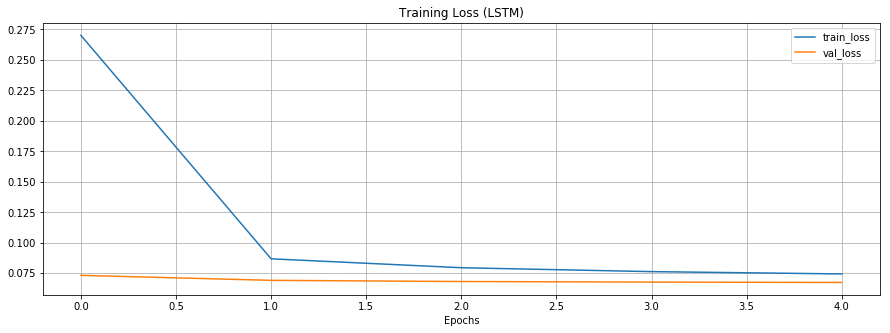

In [75]:
# Ploting the loss 
#history.history["loss"]

plt.figure(figsize=(15,5))
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
# plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
# plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
# plt.plot(np.arange(0, N), history.history["precision"], label="train_precision")
# plt.plot(np.arange(0, N), history.history["val_precision"], label="val_precision")
# plt.plot(np.arange(0, N), history.history["recall"], label="train_recall")
# plt.plot(np.arange(0, N), history.history["val_recall"], label="val_recall")
# plt.plot(np.arange(0, N), history.history["f1"], label="train_f1")
# plt.plot(np.arange(0, N), history.history["val_f1"], label="val_f1")
plt.title("Training Loss (LSTM)")
plt.xlabel("Epochs")
plt.grid()
#plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

### CNN Model Results

#### Top 1 label prediction

In [673]:
pred_classes = get_pred_classes(X_test_seq, number_of_labels = 1)
print("precision:" , metrics.precision_score(Y_test, pred_classes, average = 'samples'))
print("recall:" , metrics.recall_score(Y_test, pred_classes, average = 'samples'))
print("f1:" , metrics.f1_score(Y_test, pred_classes, average = 'samples'))

precision: 0.0618
recall: 0.03695666666666666
f1: 0.04381523809523809


#### Top 2 labels prediction

In [674]:
pred_classes = get_pred_classes(X_test_seq, number_of_labels = 2)
print("precision:" , metrics.precision_score(Y_test, pred_classes, average = 'samples'))
print("recall:" , metrics.recall_score(Y_test, pred_classes, average = 'samples'))
print("f1:" , metrics.f1_score(Y_test, pred_classes, average = 'samples'))

precision: 0.0612
recall: 0.07405
f1: 0.06286857142857143


#### Top 10 labels prediction

In [675]:
pred_classes = get_pred_classes(X_test_seq, number_of_labels = 10)
print("precision:" , metrics.precision_score(Y_test, pred_classes, average = 'samples'))
print("recall:" , metrics.recall_score(Y_test, pred_classes, average = 'samples'))
print("f1:" , metrics.f1_score(Y_test, pred_classes, average = 'samples'))

precision: 0.04088
recall: 0.23202833333333336
f1: 0.06686597742127154


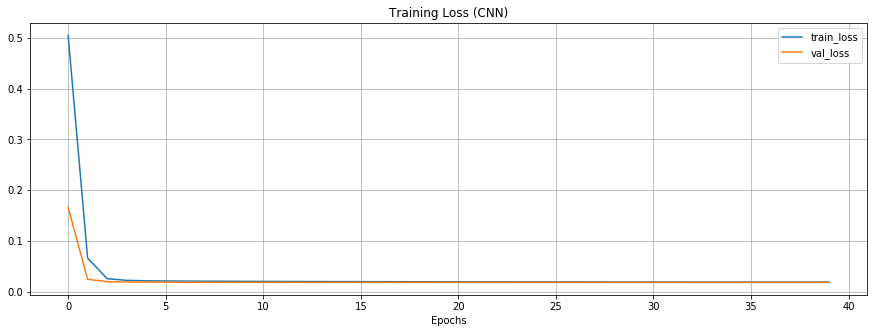

In [676]:
# Ploting the loss 
#history.history["loss"]

plt.figure(figsize=(15,5))
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
# plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
# plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
# plt.plot(np.arange(0, N), history.history["precision"], label="train_precision")
# plt.plot(np.arange(0, N), history.history["val_precision"], label="val_precision")
# plt.plot(np.arange(0, N), history.history["recall"], label="train_recall")
# plt.plot(np.arange(0, N), history.history["val_recall"], label="val_recall")
# plt.plot(np.arange(0, N), history.history["f1"], label="train_f1")
# plt.plot(np.arange(0, N), history.history["val_f1"], label="val_f1")
plt.title("Training Loss (CNN)")
plt.xlabel("Epochs")
plt.grid()
#plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

### Error Analysis

In [466]:
model.predict(X_test_seq)[100]

array([5.92865341e-04, 3.01415334e-04, 2.36083064e-02, 6.84909802e-03,
       9.69777757e-04, 8.47762823e-03, 7.70767638e-03, 6.92555564e-04,
       2.57148349e-04, 9.47743189e-04, 2.81866686e-03, 5.77301905e-03,
       3.49867769e-04, 2.39308528e-03, 1.62545344e-04, 6.92318659e-03,
       1.71949179e-03, 5.31390356e-03, 2.17994233e-03, 5.59421256e-03,
       2.58543016e-03, 8.55640756e-05, 6.04117662e-03, 2.04578438e-03,
       3.60888866e-04, 2.58674641e-04, 5.48834563e-04, 1.56376103e-04,
       1.56002294e-03, 9.74122714e-03, 4.52442886e-03, 1.04114627e-02,
       2.77904794e-04, 9.63926213e-05, 3.41320527e-03, 9.22729159e-05,
       3.09929572e-04, 6.09268136e-05, 3.77434219e-04, 2.31152866e-03,
       7.49768806e-05, 8.60306682e-05, 3.09764146e-04, 8.04160663e-04,
       8.35152750e-04, 1.29920649e-04, 6.88550994e-04, 1.70716114e-04,
       2.07651546e-03, 1.42738718e-04, 9.65562795e-05, 7.05370185e-05,
       3.47676600e-04, 6.63173487e-05, 2.58693646e-04, 5.16995694e-03,
      

In [494]:
for i in range(5):
    print(model.predict(X_test_seq)[i].argmax())
#model.predict(X_test_seq)[4].argmax()

373
117
117
373
373
